In [4]:
import numpy as np
import pandas as pd
import os, sys, re, ast, csv, math, gc, random, enum, argparse, json, requests, time  
from datetime import datetime, timedelta
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None) # to ensure console display all columns
pd.set_option('display.float_format', '{:0.3f}'.format)
pd.set_option('display.max_row', 40)
plt.style.use('ggplot')
from pathlib import Path
import joblib
from joblib import dump, load
from copy import deepcopy


dataPath = Path(r'/run/media/yen/MLData/MLProjects/UW_Insurance_Churn_Analysis/data')
pickleDataPath = dataPath / 'pickle'
dataInputPath = dataPath / 'input'
dataWorkingPath = dataPath / 'working'  


date_str = '2016-06-30'
data_df = pd.read_csv(os.path.join(dataWorkingPath / f"model_data_{date_str}.csv"))

col_cat = ['COMM_STYLE','CLAWBACK_STYLE','REGION','BENEFITCODE',
           'gender1','SMOKER1','gender2','SMOKER2','occ_class','JOINTLIFE',
           'BENESC','PRODCODE','prem_freq','product','rated']

col_num_c = ['age_life1_b','age_life2_b','initial_sum_assured_b','POLTERM_b','pol_tenure_b']


We apply binning to the numerical variables to convert them to categorical variables, to ease analysis of the distribution of these features comparing those who lapsed versus those who did not.

In [5]:
def bin_sum_assured(x):
    if x <= 0:
        return '0'
    elif x <= 10000:
        return '0-10k'
    elif x <= 20000:
        return '10k-20k'
    elif x <= 50000:
        return '20k-50k'
    elif x <= 100000:
        return '50k-100k'
    elif x <= 1000000:
        return '100k-1m'
    else:
        return '1m+'


def bin_age(x):
    if x <= 0:
        return '0'    
    elif x <= 25:
        return '0-25'
    elif x <= 35:
        return '25-35'
    elif x <= 45:
        return '35-45'
    elif x <= 55:
        return '45-55'
    else:
        return '55+'


def bin_policy_term(x):
    if x <= 10:
        return '10-'
    elif x <= 20:
        return '10-20'
    elif x <= 30:
        return '20-30'
    elif x <= 40:
        return '30-40'
    elif x <= 50:
        return '40-50'    
    elif x <= 100:
        return '50-100'       
    else:
        return '100+'


def bin_policy_tenure(x):
    if x <= 1:
        return '1-'
    elif x <= 2:
        return '1-2'
    elif x <= 5:
        return '2-5'  
    else:
        return '5+'

We use the average Z-squared statistics as a scoring measure to determing whether the distribution of features of those that lapsed are significatly different from those who didnt, to determine potentially useful features. After observing the score distribution of each of the features, we arbtrarily set the threshold to 0.01 to obtain the top features. 

We found that the 4 features below might be useful in classifying lapse:
1. CLAWBACK_STYLE: Policies with 2 year clawback seem to contain more lapses
2. SMOKER1: Policies whose policy holder are smoker seem to contain more lapses
3. age_life1: Younger policy holders are more likely to lapse
4. pol_tenure: Newer policies are more likely to lapse

CLAWBACK_STYLE Z Score: 0.02431


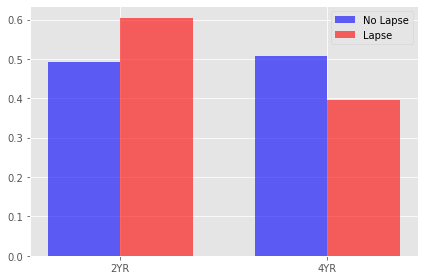

SMOKER1 Z Score: 0.01299


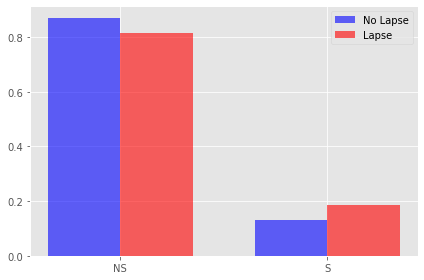

age_life1_b Z Score: 0.01047


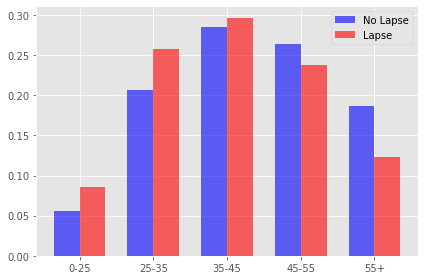

pol_tenure_b Z Score: 0.01661


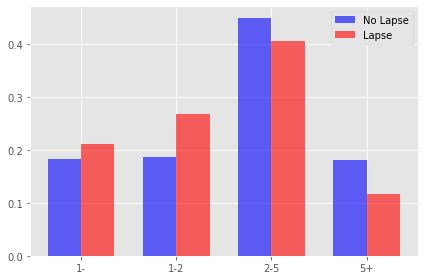

In [6]:
data_df['age_life1_b'] = data_df['age_life1'].apply(lambda x: bin_age(x))
data_df['age_life2_b'] = data_df['age_life2'].apply(lambda x: bin_age(x))
data_df['initial_sum_assured_b'] = data_df['initial_sum_assured'].apply(lambda x: bin_sum_assured(x))
data_df['POLTERM_b'] = data_df['POLTERM'].apply(lambda x: bin_policy_term(x))
data_df['pol_tenure_b'] = data_df['pol_tenure'].apply(lambda x: bin_policy_tenure(x))

data_df_lapse = data_df[data_df['target']==1].copy()
data_df_n_lapse = data_df[data_df['target']==0].copy()

score_thres = 0.01
for col in col_cat + col_num_c:
    lapse = data_df_lapse[col].value_counts()/len(data_df_lapse)
    n_lapse = data_df_n_lapse[col].value_counts()/len(data_df_n_lapse)
    n_lapse = n_lapse[n_lapse.index.isin(lapse.index)]
    lapse = lapse[lapse.index.isin(n_lapse.index)]
    lapse.sort_index(inplace=True)
    n_lapse.sort_index(inplace=True)
    score_ = sum((lapse-n_lapse)**2 / n_lapse) / len(n_lapse)
    
    if score_ > score_thres:
        print(f"{col} Z Score: {score_:,.5f}")
        labels = n_lapse.index
        n_lapse_vals = n_lapse.values
        lapse_vals = lapse.values
        x = np.arange(len(labels))  # the label locations
        width = 0.35  # the width of the bars
        
        fig, ax = plt.subplots()
        rects1 = ax.bar(x - width/2, n_lapse_vals, width, label='No Lapse', color='b', alpha=0.6)
        rects2 = ax.bar(x + width/2, lapse_vals, width, label='Lapse', color='r', alpha=0.6)
        ax.set_xticks(x, labels)
        ax.legend()
        fig.tight_layout()
        plt.show()  

The distribution of initial_sum_assured seem to contain outlier, with small number of policies having initial sum assured >= 1m. Hence, when modelling, log scaling should be applied to it to reduce the impact that it has on GLM and GAM models. Tree models are typically less affected by outliers.

In [7]:
print(f"initial_sum_assured distribution")        
for q in [0.5, 0.75, 0.9, 0.95, 0.99, 0.995, 0.999]:
    print(f"Percentile {q*100:,.1f}: {data_df['initial_sum_assured'].quantile(q):,.0f}")


initial_sum_assured distribution
Percentile 50.0: 100,000
Percentile 75.0: 200,000
Percentile 90.0: 300,000
Percentile 95.0: 465,982
Percentile 99.0: 1,000,000
Percentile 99.5: 1,000,000
Percentile 99.9: 2,000,000
